In [1]:
import tensorflow as tf
import librosa
import numpy as np
from PIL import Image

import os
from pathlib import Path

In [2]:
data_path = './test_data'
x_path = os.path.join(data_path,'x')
y_path = os.path.join(data_path,'y')

In [3]:
len(os.listdir(x_path))

100

In [4]:
hop_len = 512
freq_w = 3
octave = 8

n_bins = 12*freq_w*octave
bins_per_octave = 12*freq_w

sr = 44100
fs = 100

# TFRecord 쓰기

In [5]:
filename = "cqt-piano_roll.tfrecord"

In [6]:
writer = tf.io.TFRecordWriter(filename)
for x_file,y_file in zip(os.listdir(x_path),os.listdir(y_path)):
    example = tf.train.SequenceExample()

    example.context.feature['n_bins'].int64_list.value.append(n_bins)
    example.context.feature['bins_per_octave'].int64_list.value.append(bins_per_octave)
    example.context.feature['hop_length'].int64_list.value.append(hop_len)
    example.context.feature['freq_width'].int64_list.value.append(freq_w)
    example.context.feature['octave'].int64_list.value.append(octave)
    example.context.feature['sampling_rate'].int64_list.value.append(sr)
    example.context.feature['piano_roll_fs'].int64_list.value.append(fs)
    
    cqt_list = example.feature_lists.feature_list["x"]
    piano_roll = example.feature_lists.feature_list['y']
    
    path = os.path.join(x_path, x_file)
    audio_data, _ = librosa.load(path,sr=sr)
    cqt = librosa.cqt(audio_data, sr=sr,
                      hop_length= hop_len,
                      n_bins= 12*freq_w*octave,
                      bins_per_octave= 12*freq_w,
                     )
    x = np.abs(cqt).astype(np.float32)
    cqt_list.feature.add().bytes_list.value.append(x.tobytes())

    path = os.path.join(y_path, y_file)
    array = np.array(Image.open(path))
#     print(f"{type(array)=}")
#     print(f"{array.shape=}")
#     print(f"{array.dtype=}")
#     print(f"{array.max()=}")
#     print(f"{array.min()=}")
#     break
    piano_roll.feature.add().bytes_list.value.append(array.tobytes())
    writer.write(example.SerializeToString())

# TFRecord 읽기

In [7]:
context_description = {
    'n_bins': tf.io.FixedLenFeature([],tf.int64,
                                    default_value=(12*freq_w*octave)),
    'bins_per_octave':tf.io.FixedLenFeature([],tf.int64,
                                            default_value=(12*freq_w)),
    'hop_length':tf.io.FixedLenFeature([],tf.int64,
                                       default_value=(hop_len)),
    'freq_width':tf.io.FixedLenFeature([],tf.int64,
                                       default_value=(freq_w)),
    'octave':tf.io.FixedLenFeature([],tf.int64,
                                   default_value=(octave)),
    'sampling_rate':tf.io.FixedLenFeature([],tf.int64,
                                          default_value=(sr)),
    'piano_roll_fs':tf.io.FixedLenFeature([],tf.int64,
                                          default_value=(fs)),
}

sequence_description = {
    'x': tf.io.FixedLenSequenceFeature([], tf.string),
    'y': tf.io.FixedLenSequenceFeature([], tf.string),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_sequence_example(example_proto,
                                             context_description,
                                             sequence_description,)

In [8]:
import matplotlib.pyplot as plt
import librosa.display

raw_ds = tf.data.TFRecordDataset(filename)
parsed_ds = raw_ds.map(_parse_function)
for ds in parsed_ds.take(1):
    print(type(ds))
    print(len(ds))
    print(type(ds[0]))
    print(ds[0].keys())
    print(type(ds[1]))
    print(ds[1].keys())
    
    context, sequence = ds

<class 'tuple'>
2
<class 'dict'>
dict_keys(['bins_per_octave', 'freq_width', 'hop_length', 'n_bins', 'octave', 'piano_roll_fs', 'sampling_rate'])
<class 'dict'>
dict_keys(['x', 'y'])


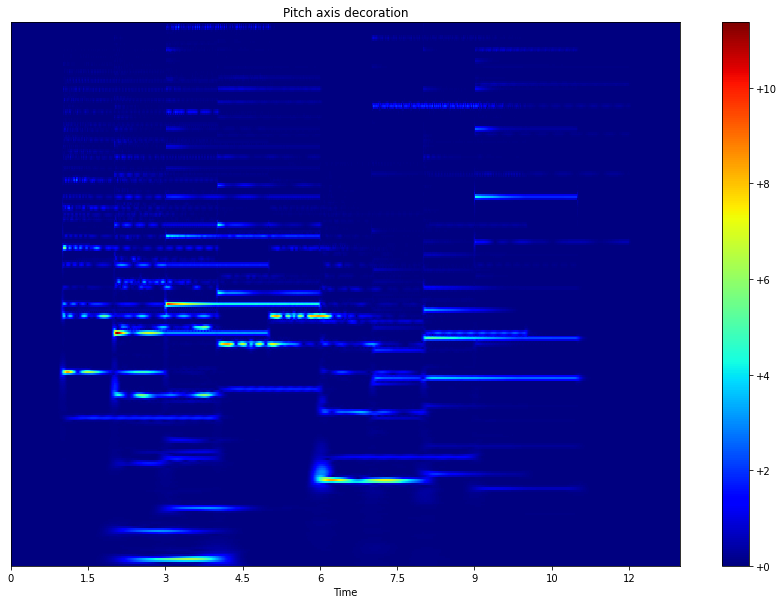

In [9]:
cqt = tf.io.decode_raw(sequence['x'],tf.float32).numpy().reshape(n_bins,-1)
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(cqt[:,:], sr=sr, x_axis='time', ax=ax, hop_length= hop_len, bins_per_octave= 12*freq_w,
                               cmap='jet'
                               )
ax.set(title='Pitch axis decoration')
fig.colorbar(img, ax=ax, format="%+2d")
# for i in beat_times:
#     ax.axvline(i,c='k')

plt.show()

C:\Users\AI_server\miniconda3\envs\MA\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


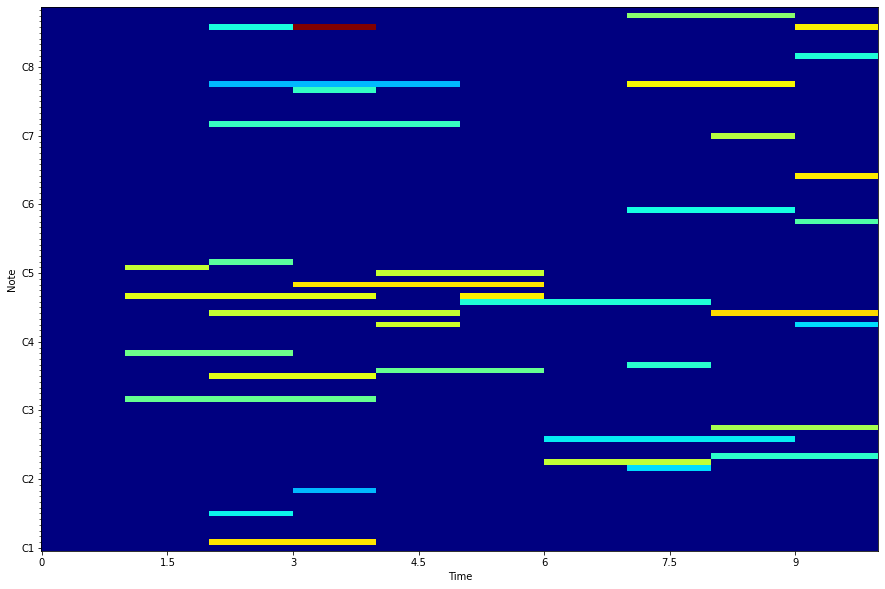

In [10]:
import pretty_midi_fluidsynth as pmf

piano_roll = tf.io.decode_raw(sequence['y'],tf.uint8).numpy().reshape(128,-1)

start_pitch = 24
end_pitch = 119

plt.figure(figsize=(15,10))
librosa.display.specshow(
    piano_roll[start_pitch:end_pitch,:fs*10],
    hop_length=1,
    sr=fs,
    x_axis='time',
    y_axis='cqt_note',
    cmap='jet',
    fmin=pmf.note_number_to_hz(start_pitch)
)
plt.show()

# piano_roll to midi

In [11]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pmf.PrettyMIDI()
    instrument = pmf.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pmf.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [13]:
midi_data = piano_roll_to_pretty_midi(piano_roll,fs)
midi_data.write('sample.mid')